# Qual a abrangência de um ponto de ônibus na cidade de são paulo?
Essa pergunta me ocorreu estes dias, e somado a isso a distância que uma pessoa precisa percorrer para chegar a um ponto de onibus, lembrando que as regiões tem declividade e que isso pode afetar a sensação de distância entre um ponto de ônibus e o local de origem.
Além deste fato, vou verificar a densidade populacional das áres (aproximada) que pode ser um indicativo de quanto o ponto de ônibus abrange a população

### Bom vamos ver a análise de dados
Em primeiro lugar vamos importar os módulos. Como os arquivos da prefeitura são shapes, precisaremos de uma biblioteca para isso. E naturalmente outra para visualizar os dados. Eu optarei pelo matplotlib. Em seguida como precisaremos de um algoritimo próprio parar este tipo de análise. Usarei voronoi.

### Dados Utilizados
Os dados foram obtidos da plataforma da prefeitura da cidade de são paulo:
http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx
os dados baixados são :
* Localiação dos pontos de ônibus
* Densidade demográfica
* Topografia


In [24]:
import geopandas as gpd
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import re
import numpy as np

%matplotlib inline


# Primeiros passos
Em análise de dados é sempre bom primeiramente darmos uma olhada nos dados, o site em que eu fiz os downloads já me deram algumas dicas do que temos nos arquiovs mas é sempre bom conferir!

Index(['geometry', 'pt_descric', 'pt_enderec', 'pt_nome'], dtype='object')


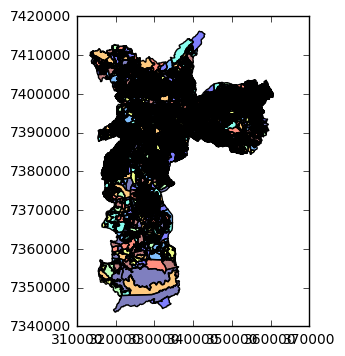

In [6]:
pontos = gpd.read_file('../GIS/DadosSampa/SIRGAS_SHP_pontoonibus/SIRGAS_SHP_pontoonibus_point.shp')
print(pontos.columns)
densidade = gpd.read_file('../GIS/DadosSampa/SIRGAS_SHP_densidade_demografica_2010.shp')
densidade.head()

densidade.plot()

bom temos os dados da cidade, aparentemente esta tudo em ordem, vou precisar lembrar de remover as linhas se for plotar mais alguma coisa

Me ocorreu que a análise de voronoi não pode ser diretamente aplicada. pois no caso de ponto de ônibus na mesma rua será interessante considera-los como um único, pois dessa forma considera-se como 1 o ponto de ônibus de ida e volta, que em quase todos os casos não é o mesmo. Portanto esta é mais uma implicação da análise. Vou começar a resolver o problema por aí.

In [10]:
# olhando o cabeçalho dos pontos de ônibus
pontos.head()


,geometry,pt_descric,pt_enderec,pt_nome
0,POINT (319094.8392643448 7385513.190575708),Ref.: R Campina Grande/ Av Vitor Gabriel,R Campina Grande/ Av Vitor Gabriel,Terminal Campo Limpo
1,POINT (349413.6174407193 7387737.499860981),Ref.: Av Sapopemba/ Pc Felisberto Fernandes Da...,Av Sapopemba/ Pc Felisberto Fernandes Da Silva,Terminal S. Mateus - Plat. C
2,POINT (332582.4540150195 7378078.002008434),Ref.: R Dos Curimatas/ R Delfim Do Prata,R Dos Curimatas/ R Delfim Do Prata,"R. Cardoso De Melo Neto, 497"
3,POINT (350253.9040314286 7389086.161001192),Ref.: Rua Forte Do Araxá / Forte Do Rio Negro,Rua Forte Do Araxá / Forte Do Rio Negro,"Av. Forte Do Leme, 360"
4,POINT (349019.6847513096 7393468.142417993),Ref.: R Carlos Jose De Castilho/ R Seis,R Carlos Jose De Castilho/ R Seis,"R. Morubixaba, 69"


Bom os nomes do ponto apresentam a numeração da rua separado por vírgula. Assumindo que os pontos opostos para ida e volta estão na mesma rua, porém um com numeração ímpar e outro com numeração par vou criar um indicador que vai apontar o número do ponto de ônibus e outro para se par ou se impar

In [19]:
# pegar os numeros dos pontos

def CheckOddNumber(x):
    texts = x.split(',')
    if len(texts)==1:
        odd=None
    else:
        try:
            odd=int(texts[-1])% 2
        except:
            print(texts)
            odd=None
            pass
        
    return odd

pontos['StreetSide'] = pontos['pt_nome'].apply(CheckOddNumber)

pontos.head()

            
            

['R. Mmdc', ' 380 Ref.: Rua Camargo (lateral Do Terminal Butantã)']
['Pça. Manoel Liodoro Da Silva', ' 900 Ref.: R Anajazeira / R Anton']
['R. Mmdc', ' 364 Ref.: Lateral Terminal Butantã']


,geometry,pt_descric,pt_enderec,pt_nome,StreetSide
0,POINT (319094.8392643448 7385513.190575708),Ref.: R Campina Grande/ Av Vitor Gabriel,R Campina Grande/ Av Vitor Gabriel,Terminal Campo Limpo,NaN
1,POINT (349413.6174407193 7387737.499860981),Ref.: Av Sapopemba/ Pc Felisberto Fernandes Da...,Av Sapopemba/ Pc Felisberto Fernandes Da Silva,Terminal S. Mateus - Plat. C,NaN
2,POINT (332582.4540150195 7378078.002008434),Ref.: R Dos Curimatas/ R Delfim Do Prata,R Dos Curimatas/ R Delfim Do Prata,"R. Cardoso De Melo Neto, 497",1.0
3,POINT (350253.9040314286 7389086.161001192),Ref.: Rua Forte Do Araxá / Forte Do Rio Negro,Rua Forte Do Araxá / Forte Do Rio Negro,"Av. Forte Do Leme, 360",0.0
4,POINT (349019.6847513096 7393468.142417993),Ref.: R Carlos Jose De Castilho/ R Seis,R Carlos Jose De Castilho/ R Seis,"R. Morubixaba, 69",1.0


Tive um erro aqui no dados, há 3 nomes que não se encaixaram no algoritimo. Bom a solução será a alteração do algoritimo para considerar estas situações, em seguida vou aproveitar extrair o nome da rua para a correlação

In [23]:
# pegar os numeros dos pontos
def CheckOddNumber(x):
    texts = x.split(',')
    if len(texts)==1:
        odd=None
    else:
        texts = re.findall(r'\d+',texts[-1])[0]
        odd=int(texts)% 2
        
    return odd

pontos['StreetSide'] = pontos['pt_nome'].apply(CheckOddNumber)

def StopName(x):
    StreetName = x.split(',')
    return StreetName[0]
    
pontos['StreetName'] = pontos['pt_nome'].apply(StopName)
pontos.head()


,geometry,pt_descric,pt_enderec,pt_nome,StreetSide,StreetName
0,POINT (319094.8392643448 7385513.190575708),Ref.: R Campina Grande/ Av Vitor Gabriel,R Campina Grande/ Av Vitor Gabriel,Terminal Campo Limpo,NaN,Terminal Campo Limpo
1,POINT (349413.6174407193 7387737.499860981),Ref.: Av Sapopemba/ Pc Felisberto Fernandes Da...,Av Sapopemba/ Pc Felisberto Fernandes Da Silva,Terminal S. Mateus - Plat. C,NaN,Terminal S. Mateus - Plat. C
2,POINT (332582.4540150195 7378078.002008434),Ref.: R Dos Curimatas/ R Delfim Do Prata,R Dos Curimatas/ R Delfim Do Prata,"R. Cardoso De Melo Neto, 497",1.0,R. Cardoso De Melo Neto
3,POINT (350253.9040314286 7389086.161001192),Ref.: Rua Forte Do Araxá / Forte Do Rio Negro,Rua Forte Do Araxá / Forte Do Rio Negro,"Av. Forte Do Leme, 360",0.0,Av. Forte Do Leme
4,POINT (349019.6847513096 7393468.142417993),Ref.: R Carlos Jose De Castilho/ R Seis,R Carlos Jose De Castilho/ R Seis,"R. Morubixaba, 69",1.0,R. Morubixaba



Verificar quantas ruas temos com pontos de onibus e qual a distribução de pontos por rua (desconsiderando as ruas com até três ponto por conta de provavelmente serem a maior ocorrencia)


O numero de ruas, avenidas e terminais com pontos de ônibus é de :5895
Destes, 25.48% apresentam mais de 3 pontos de parada


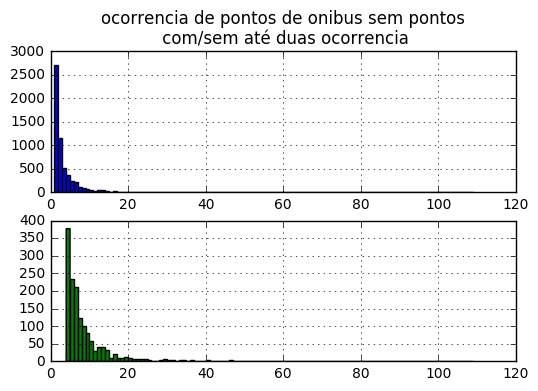

In [67]:
nruas = len(pontos.StreetName.unique())


pontosDeOnibusPorRua = pontos.StreetName.value_counts()

fig, axes = plt.subplots(nrows=2, ncols=1)
ax1,ax2=axes

pontosDeOnibusPorRua.hist(ax=ax1,bins=range(1,110))
pontosDeOnibusPorRua.loc[pontosDeOnibusPorRua>3].hist(bins=range(4,110),ax=ax2,color='green')

ax1.set_title('ocorrencia de pontos de onibus sem pontos\n com/sem até duas ocorrencia')

NRuasMaisPontos = pontosDeOnibusPorRua.loc[pontosDeOnibusPorRua>3].shape[0]

print('O numero de ruas, avenidas e terminais com pontos de ônibus é de :{}'.format(nruas))
print('Destes, {:0.2f}% apresentam mais de 3 pontos de parada'.format(NRuasMaisPontos/nruas*100))

Agora que tenho uma noção do tamanho do problema vamos começar a misturar as coisas, primeiro descobrir quais ruas tem um ponto de cada lado

In [89]:
# Sum indicadores
SomaDosIndicadores=pontos.groupby('StreetName')['StreetSide'].sum().dropna()
SomaDosIndicadores = SomaDosIndicadores.loc[SomaDosIndicadores>0]
# gets same index
SomaDosIndicadores = SomaDosIndicadores.loc[pontosDeOnibusPorRua.index].dropna()
SelRuas = pontosDeOnibusPorRua.loc[SomaDosIndicadores.index].sort_values()-SomaDosIndicadores.sort_values()
SelRuas=SelRuas[SelRuas>0]



Agora que as ruas já foram selecionadas, vamos começar com o processamento que vai demorar um tanto por conta do numero de interações

In [ ]:
for ruas in SelRuas:
    
    
    
    